# Лабораторная работа №3. Однофакторный дисперсионный анализ

> Вариант № 4

**Распределения**:

$X_1$ ~ R(5,15) (объём выборки $n_1$ &mdash; 100)

$X_2$ ~ N(10,5) (объём выборки $n_2$ &mdash; 100)

$X_3$ ~ N(10,2) (объём выборки $n_3$ &mdash; 100)

$X_4$ ~ N(10,5) (объём выборки $n_4$ &mdash; 100)

In [57]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, PooledSample, BartlettHyp, OneWayAnovaHyp, LinearContrastHyp
from s.utils import table, printf

## 1. Исходные данные

In [58]:
X1 = stats.uniform(5,15)
X2 = stats.norm(10,np.sqrt(5))
X3 = stats.norm(10,np.sqrt(2))
X4 = stats.norm(10,np.sqrt(5))

n1 = 100
n2 = 100
n3 = 100
n4 = 100
n = n1 + n2 + n3 + n4

print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X1', 'R', '$a=5, b=15$', X1.mean(), X1.var(), n1],
        ['X2', 'N', '$m=10, \\sigma^2=5$', X2.mean(), round(X2.var(), 4), n2],
        ['X3', 'N', '$m=10, \\sigma^2=2$', X3.mean(), round(X3.var(), 4), n3],
        ['X4', 'N', '$m=10, \\sigma^2=5$', X4.mean(), round(X4.var(), 4), n4]
    ]
)
printf('Количество случайных величин $k={}$', 4)
    

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X1,R,"$a=5, b=15$",12.5,18.75,100
X2,N,"$m=10, \sigma^2=5$",10.0,5.0,100
X3,N,"$m=10, \sigma^2=2$",10.0,2.0,100
X4,N,"$m=10, \sigma^2=5$",10.0,5.0,100


In [59]:
x1 = Sample.from_distribution("x1", X1, count=n1)
x2 = Sample.from_distribution("x2", X2, count=n2)
x3 = Sample.from_distribution("x3", X3, count=n3)
x4 = Sample.from_distribution("x4", X4, count=n4)

x_pooled = PooledSample("Pooled", x1, x2, x3, x4)

print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x1, x2, x3, x4, x_pooled]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x1,12.7509,19.9508,4.4666
x2,10.3841,5.8326,2.4151
x3,10.1391,2.0244,1.4228
x4,10.1652,5.7412,2.3961
Pooled,10.8598,9.5283,3.0868


## 2. Визуальное представление выборок

Диаграммы *Box-and-Whisker*:

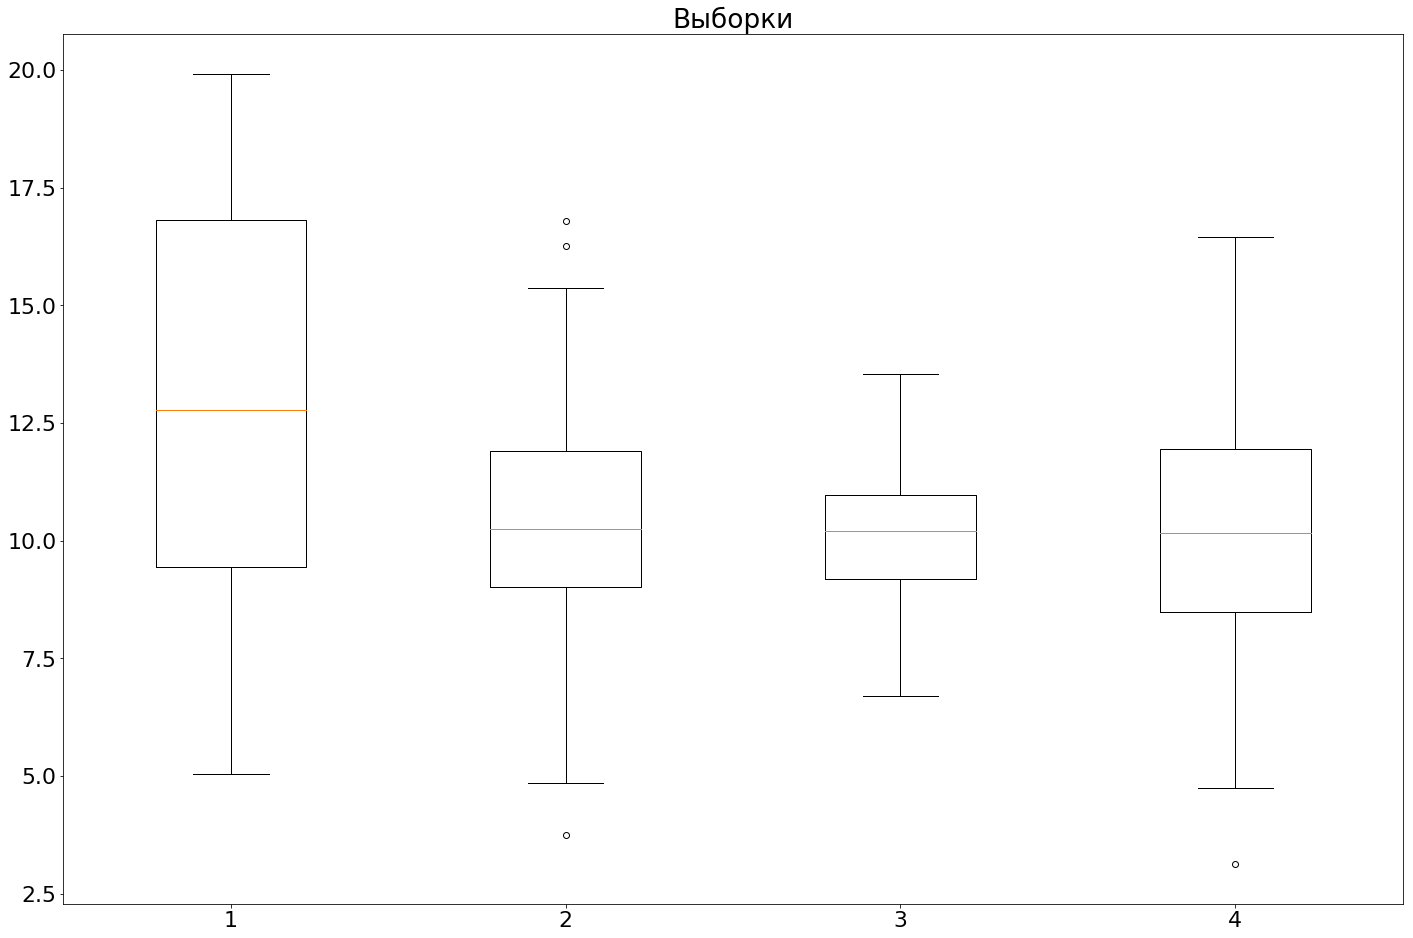

In [60]:
fig, ax = plt.subplots()

ax.boxplot([x1.data(), x2.data(), x3.data(), x4.data()])
ax.set_title('Выборки')

plt.show()

## 3. Проверка условия применимости дисперсионного анализа

Статистическая гипотеза $H_0: \sigma_1^2 = \sigma_2^2 = \sigma_3^2 = \sigma_4^2$

In [61]:
print('Критерий Бартлетта')

alpha = 0.05

H0 = BartlettHyp(x_pooled)
criterion_value, interval, p_value, result = H0.full_test(x_pooled, alpha)

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        'H0' if result else 'H1',
        'Ошибка второго рода' if result else '-'
    ]]
)

Критерий Бартлетта


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
127.8841,0.0,H1,-


## 4. Однофакторный дисперсионный анализ

In [62]:
K = 4
print('Таблица дисперсионного анализа')
# http://datalearning.ru/index.php/textbook?cid=1&mid=5&topic=2, таблица 6.4
Db = x_pooled.between_group_var()
Dw = x_pooled.within_group_var()
Dx = x_pooled.var()
table(
    ['Источник вариации', 'Показатель вариации', 'Число степеней свободы', 'Несмещённая оценка'],
    [
        ['Группировочный признак', Db, K-1, n/(K-1)*Db],
        ['Остаточные признаки', Dw, n-K, n/(n-K)*Dw],
        ['Все признаки', Dx, n-1, n/(n-1)*Dx]
    ]
)

eta2 = x_pooled.eta_squared()
printf('Эмпирический коэффициент детерминации $\\eta^2 = {}$', round(eta2, 4))
printf('Эмпирическое корреляционное отношение $\\eta = {}$', round(np.sqrt(eta2), 4))

Таблица дисперсионного анализа


Источник вариации,Показатель вариации,Число степеней свободы,Несмещённая оценка
Группировочный признак,1.2011311686529402,3,160.15082248705872
Остаточные признаки,8.30333891203612,396,8.387211022258708
Все признаки,9.50447008068906,399,9.52829080770833


Статистическая гипотеза $H_0: m_1 = m_2 = m_3 = m_4$

In [63]:
alpha = 0.05

anova = OneWayAnovaHyp(x_pooled)
criterion_value, (crit_left, crit_right), p_value, result = anova.full_test(x_pooled, alpha)

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        'H0' if result else 'H1',
        'Ошибка 2-го рода' if result else '-',
    ]]
)


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
19.0946,0.0,H1,-


## 5. Метод линейных контрастов

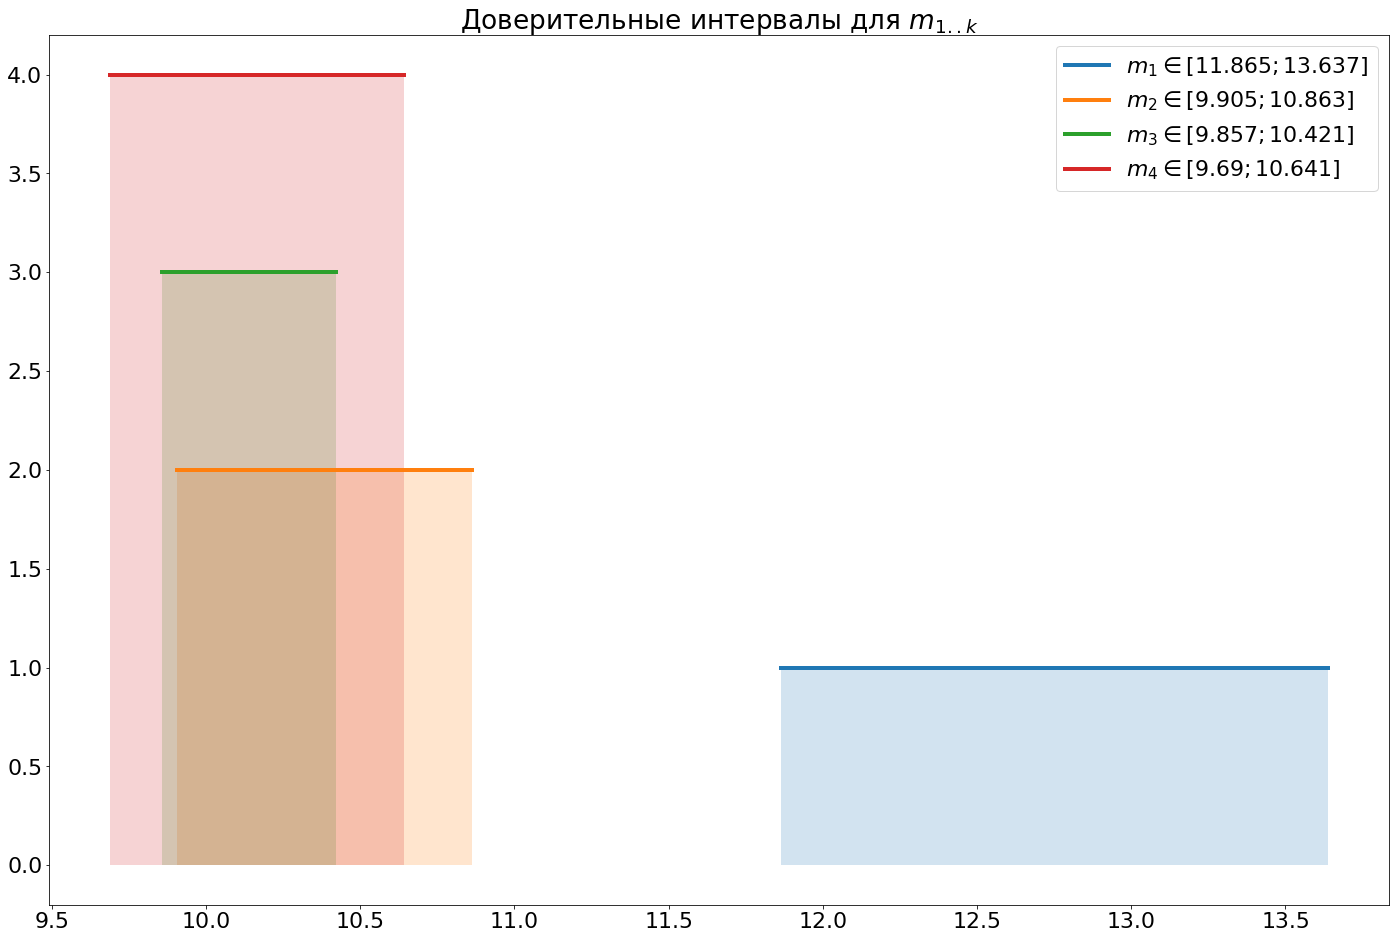

Гипотеза,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$m_1=m_2$,2.3668,0.1409,$\ne$,-
$m_1=m_3$,2.6118,0.1021,$\ne$,-
$m_1=m_4$,2.6118,0.1021,$\ne$,-
$m_2=m_3$,0.245,0.2702,$\ne$,Ошибка первого рода
$m_2=m_4$,0.2189,0.2334,$=$,-
$m_3=m_4$,-0.0261,0.0,$=$,-


In [64]:
alpha = 0.05

def m_interval(sample):
    n = sample.n()
    delta = stats.t(n - 1).ppf(1 - alpha / 2) * sample.s() / np.sqrt(n)
    mean = sample.mean()
    return mean - delta, mean + delta
    
fig, ax = plt.subplots()
ax.set_title('Доверительные интервалы для $m_{1..k}$')

samples = [x1, x2, x3, x4]
for i in range(len(samples)):
    l, r = m_interval(samples[i])
    domain = [l, r]
    values = [i + 1, i + 1]
    ax.plot(
        domain,
        values,
        label='$m_{} \\in [{}; {}]$'.format(i + 1, round(l, 3), round(r, 3)),
        linewidth=4
    )
    ax.fill_between(domain, 0, values, alpha=.2)

plt.legend()
plt.show()

H0 = LinearContrastHyp(x_pooled)
def table_row(Hypo, coeffs, expected):
    c, (c_1, c_2), p_value, result = H0.full_test(coeffs, alpha=alpha)
    decision = '$=$' if result else '$\\ne$'
    err = "-" if expected == decision else ("Ошибка первого рода" if expected == '$=$' else "Ошибка второго рода")
    
    return Hypo, round(c,4), round(p_value, 4), decision, err

table(
    [
        'Гипотеза',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        table_row('$m_1=m_2$', [1, -1, 0, 0], '$\\ne$'),
        table_row('$m_1=m_3$', [1, 0, -1, 0], '$\\ne$'),
        table_row('$m_1=m_4$', [1, 0, -1, 0], '$\\ne$'),
        table_row('$m_2=m_3$', [0, 1, -1, 0], '$=$'),
        table_row('$m_2=m_4$', [0, 1, 0, -1], '$=$'),
        table_row('$m_3=m_4$', [0, 0, 1, -1], '$=$'),
    ]
)